<a href="https://colab.research.google.com/github/Gaurav7888/Adversarial-Attacks-and-Defence/blob/main/MoreImageBasedAttacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip ijcnn19attacks-master.zip

In [ ]:
!pip3 install -r /content/ijcnn19attacks-master/src/pip-requirements.txt

In [ ]:
!python3 /content/ijcnn19attacks-master/src/main.py attack fgsm 

2023-04-07 14:31:16.617317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 14:31:18.229308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/ijcnn19attacks-master/src/main.py", line 11, in <module>
    import cleverhans_tutorials.tsc_tutorial_keras_tf as attack
  File "/content/ijcnn19attacks-master/src/cleverhans_tutorials/tsc_tutorial_keras_tf.py", line 15, in <module>
    from cleverhans_copy.attacks import FastGradientMethod
  File "/content/ijcnn19attacks-master/src/cleverhans_copy/attacks.py", line 13, in <module>
    from cleverhans_copy.utils_tf import clip_eta
  File "/content/ijcnn19attacks-master/src/cleverhans_copy/utils_tf.py", line

In [ ]:
pip install torchattacks


In [ ]:
import sys

import torch
import torch.nn as nn

sys.path.insert(0, '..')
import torchattacks

In [ ]:
sys.path.insert(0, '..')
import robustbench
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy

images, labels = load_cifar10(n_examples=5)
print('[Data loaded]')

device = "cuda"
model = load_model('Standard', norm='Linf').to(device)
acc = clean_accuracy(model, images.to(device), labels.to(device))
print('[Model loaded]')
print('Acc: %2.2f %%'%(acc*100))

In [ ]:
!touch util.py


In [ ]:
from torchattacks import PGD
from utils import imshow, get_pred

In [ ]:
atk = PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
print(atk)

PGD(model_name=WideResNet, device=cuda:0, attack_mode=default, targeted=False, normalization_used=False, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)


In [ ]:
adv_images = atk(images, labels)

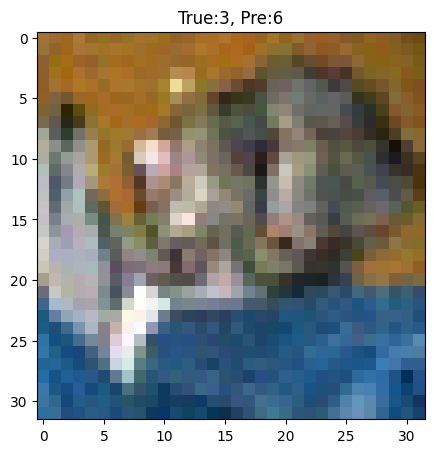

In [ ]:
idx = 0
pre = get_pred(model, adv_images[idx:idx+1], device)
imshow(adv_images[idx:idx+1], title="True:%d, Pre:%d"%(labels[idx], pre))

In [ ]:
import sys

import torch
import torch.nn as nn

sys.path.insert(0, '..')
import torchattacks

In [ ]:
from robustbench.data import load_cifar10
from robustbench.utils import load_model, clean_accuracy
from utils import l2_distance

images, labels = load_cifar10(n_examples=50)
device = "cuda"

Files already downloaded and verified


In [ ]:
model_list = ['Standard', 'Wong2020Fast', 'Rice2020Overfitting']
for model_name in model_list:
    model = load_model(model_name, norm='Linf').to(device)
    acc = clean_accuracy(model, images.to(device), labels.to(device))
    print('Model: {}'.format(model_name))
    print('- Standard Acc: {}'.format(acc))

Model: Standard
- Standard Acc: 0.96
Model: Wong2020Fast
- Standard Acc: 0.92
Model: Rice2020Overfitting
- Standard Acc: 0.86


In [ ]:
!pip install foolbox art

In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
import datetime
import numpy as np
import warnings

warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.optim as optim

# https://github.com/bethgelab/foolbox
import foolbox as fb
print("foolbox %s"%(fb.__version__))

# https://github.com/IBM/adversarial-robustness-toolbox
import art
import art.attacks.evasion as evasion
from art.estimators.classification import PyTorchClassifier
print("art %s"%(art.__version__))

import sys
sys.path.insert(0, '..')
# https://github.com/Harry24k/adversarial-attacks-pytorch
import torchattacks
print("torchattacks %s"%(torchattacks.__version__))

foolbox 3.3.3
art 1.14.0
torchattacks 3.4.0


In [ ]:
for model_name in model_list:
    print('Model: {}'.format(model_name))
    model = load_model(model_name, norm='Linf').to(device)
    
    print("- Torchattacks")
    atk = torchattacks.FGSM(model, eps=8/255)
    start = datetime.datetime.now()
    adv_images = atk(images, labels)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))
    
    print("- Foolbox")
    fmodel = fb.PyTorchModel(model, bounds=(0, 1))
    atk = fb.attacks.LinfFastGradientAttack(random_start=False)
    start = datetime.datetime.now()
    _, adv_images, _ = atk(fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=8/255)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))
    
    print("- ART")
    classifier = PyTorchClassifier(model=model, clip_values=(0, 1),
                                   loss=nn.CrossEntropyLoss(),
                                   optimizer=optim.Adam(model.parameters(), lr=0.01),
                                   input_shape=(3, 32, 32), nb_classes=10)
    atk = evasion.FastGradientMethod(norm=np.inf, batch_size=50,
                                     estimator=classifier, eps=8/255)
    start = datetime.datetime.now()
    #adv_images = torch.tensor(atk.generate(images, labels)).to(device)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))
    
    print()

Model: Standard
- Torchattacks
- Robust Acc: 0.34 (10 ms)
- Foolbox
- Robust Acc: 0.34 (16 ms)
- ART
- Robust Acc: 0.34 (0 ms)

Model: Wong2020Fast
- Torchattacks
- Robust Acc: 0.48 (14 ms)
- Foolbox
- Robust Acc: 0.48 (13 ms)
- ART
- Robust Acc: 0.48 (0 ms)

Model: Rice2020Overfitting
- Torchattacks
- Robust Acc: 0.62 (18 ms)
- Foolbox
- Robust Acc: 0.62 (20 ms)
- ART
- Robust Acc: 0.62 (0 ms)



In [ ]:
for model_name in model_list:
    print('Model: {}'.format(model_name))
    model = load_model(model_name, norm='Linf').to(device)
    
    print("- Torchattacks")
    atk = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=10)
    start = datetime.datetime.now()
    adv_images = atk(images, labels)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))
    
    print("- Foolbox")
    fmodel = fb.PyTorchModel(model, bounds=(0, 1))
    atk = fb.attacks.LinfBasicIterativeAttack(abs_stepsize=2/255, steps=10, random_start=False)
    start = datetime.datetime.now()
    _, adv_images, _ = atk(fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=8/255)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))
    
    print("- ART")
    classifier = PyTorchClassifier(model=model, clip_values=(0, 1),
                                   loss=nn.CrossEntropyLoss(),
                                   optimizer=optim.Adam(model.parameters(), lr=0.01),
                                   input_shape=(3, 32, 32), nb_classes=10)
    atk = evasion.BasicIterativeMethod(batch_size=50,
                                       estimator=classifier, eps=8/255,
                                       eps_step=2/255, max_iter=10)
    start = datetime.datetime.now()
    #adv_images = torch.tensor(atk.generate(images, labels)).to(device)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    print('- Robust Acc: {} ({} ms)'.format(acc, int((end-start).total_seconds()*1000)))
    
    print()

Model: Standard
- Torchattacks
- Robust Acc: 0.0 (1184 ms)
- Foolbox
- Robust Acc: 0.0 (1821 ms)
- ART
- Robust Acc: 0.0 (0 ms)

Model: Wong2020Fast
- Torchattacks
- Robust Acc: 0.44 (170 ms)
- Foolbox
- Robust Acc: 0.44 (297 ms)
- ART
- Robust Acc: 0.44 (0 ms)

Model: Rice2020Overfitting
- Torchattacks
- Robust Acc: 0.58 (4523 ms)
- Foolbox
- Robust Acc: 0.58 (7249 ms)
- ART
- Robust Acc: 0.58 (0 ms)



In [ ]:
for model_name in model_list:
    print('Model: {}'.format(model_name))
    model = load_model(model_name, norm='Linf').cuda()
    
    print("- Torchattacks")
    atk = torchattacks.PGDL2(model, eps=128/255, alpha=15/255, steps=10, random_start=False)
    start = datetime.datetime.now()
    adv_images = atk(images, labels)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    l2 = l2_distance(model, images, adv_images, labels, device=device)
    print('- Robust Acc: {} / L2: {:1.2} ({} ms)'.format(acc, l2,
                                                         int((end-start).total_seconds()*1000)))
    
    print("- Foolbox")
    fmodel = fb.PyTorchModel(model, bounds=(0, 1))
    atk = fb.attacks.L2PGD(abs_stepsize=15/255, steps=10, random_start=False)
    start = datetime.datetime.now()
    _, adv_images, _ = atk(fmodel, images.to('cuda:0'), labels.to('cuda:0'), epsilons=128/255)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    l2 = l2_distance(model, images, adv_images, labels, device=device)
    print('- Robust Acc: {} / L2: {:1.2} ({} ms)'.format(acc, l2,
                                                         int((end-start).total_seconds()*1000)))
    
    print("- ART")
    classifier = PyTorchClassifier(model=model, clip_values=(0, 1),
                                   loss=nn.CrossEntropyLoss(),
                                   optimizer=optim.Adam(model.parameters(), lr=0.01),
                                   input_shape=(3, 32, 32), nb_classes=10)
    atk = evasion.ProjectedGradientDescent(batch_size=50, num_random_init=0,
                                           norm = 2, estimator=classifier, eps=128/255,
                                           eps_step=15/255, max_iter=10)
    start = datetime.datetime.now()
    #adv_images = torch.tensor(atk.generate(images, labels)).to(device)
    end = datetime.datetime.now()
    acc = clean_accuracy(model, adv_images, labels)
    l2 = l2_distance(model, images, adv_images, labels, device=device)
    print('- Robust Acc: {} / L2: {:1.2} ({} ms)'.format(acc, l2,
                                                         int((end-start).total_seconds()*1000)))
    
    print()

Model: Standard
- Torchattacks
- Robust Acc: 0.06 / L2: 0.41 (1186 ms)
- Foolbox
- Robust Acc: 0.06 / L2: 0.41 (1874 ms)
- ART
- Robust Acc: 0.06 / L2: 0.41 (0 ms)

Model: Wong2020Fast
- Torchattacks
- Robust Acc: 0.68 / L2: 0.5 (169 ms)
- Foolbox
- Robust Acc: 0.68 / L2: 0.5 (307 ms)
- ART
- Robust Acc: 0.68 / L2: 0.5 (0 ms)

Model: Rice2020Overfitting
- Torchattacks
- Robust Acc: 0.7 / L2: 0.5 (4576 ms)
- Foolbox
- Robust Acc: 0.7 / L2: 0.5 (7431 ms)
- ART
- Robust Acc: 0.7 / L2: 0.5 (0 ms)



In [ ]:
pip install deeprobust 

In [ ]:
import deeprobust.image.netmodels.train_model as trainmodel
trainmodel.train('CNN', 'MNIST', 'cuda', 20)

100%|██████████| 9912422/9912422 [00:00<00:00, 151162966.87it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 109923497.12it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33116534.09it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2224229.86it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302714
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.457753
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.619954
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.302887
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.287322
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.318053
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.179605
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.116807
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.254578
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.162175
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.083016
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.212397
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.134658
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.150057
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.148373
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.092181
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.075467
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.164516
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.049869

In [ ]:
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.config import attack_params
from deeprobust.image.utils import download_model
import torch
import deeprobust.image.netmodels.resnet as resnet
from torchvision import transforms,datasets

URL = "https://github.com/I-am-Bot/deeprobust_model/raw/master/CIFAR10_ResNet18_epoch_20.pt"
download_model(URL, "$MODEL_PATH$")

model = resnet.ResNet18().to('cuda')
model.load_state_dict(torch.load("$MODEL_PATH$"))
model.eval()

transform_val = transforms.Compose([transforms.ToTensor()])
test_loader  = torch.utils.data.DataLoader(
                datasets.CIFAR10('deeprobust/image/data', train = False, download=True,
                transform = transform_val),
                batch_size = 10, shuffle=True)

x, y = next(iter(test_loader))
x = x.to('cuda').float()

adversary = PGD(model, 'cuda')
Adv_img = adversary.generate(x, y, **attack_params['PGD_CIFAR10'])

Dowloading from https://github.com/I-am-Bot/deeprobust_model/raw/master/CIFAR10_ResNet18_epoch_20.pt to $MODEL_PATH$


100%|██████████| 170498071/170498071 [00:05<00:00, 30008336.34it/s]


Extracting deeprobust/image/data/cifar-10-python.tar.gz to deeprobust/image/data
iteration 0, loss:2.6360
iteration 1, loss:6.2877
iteration 2, loss:10.0464
iteration 3, loss:13.1141
iteration 4, loss:15.6711
iteration 5, loss:17.8459
iteration 6, loss:19.6432
iteration 7, loss:21.1475
iteration 8, loss:22.4984
iteration 9, loss:23.6676
iteration 10, loss:24.7098
iteration 11, loss:25.5908
iteration 12, loss:26.3762
iteration 13, loss:27.0614
iteration 14, loss:27.7259
iteration 15, loss:28.2895
iteration 16, loss:28.7729
iteration 17, loss:29.2375
iteration 18, loss:29.6516
iteration 19, loss:30.0581
iteration 20, loss:30.4377
iteration 21, loss:30.7378
iteration 22, loss:31.0175
iteration 23, loss:31.3298
iteration 24, loss:31.5348
iteration 25, loss:31.8099
iteration 26, loss:32.0336
iteration 27, loss:32.2669
iteration 28, loss:32.4365
iteration 29, loss:32.6762
iteration 30, loss:32.8328
iteration 31, loss:33.0325
iteration 32, loss:33.1323
iteration 33, loss:33.3040
iteration 34,

In [ ]:
from deeprobust.image.defense.pgdtraining import PGDtraining
from deeprobust.image.config import defense_params
from deeprobust.image.netmodels.CNN import Net
import torch
from torchvision import datasets, transforms 

model = Net()
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('deeprobust/image/defense/data', train=True, download=True,
                                transform=transforms.Compose([transforms.ToTensor()])),
                                batch_size=100,shuffle=True)

test_loader = torch.utils.data.DataLoader(
              datasets.MNIST('deeprobust/image/defense/data', train=False,
                            transform=transforms.Compose([transforms.ToTensor()])),
                            batch_size=1000,shuffle=True)

defense = PGDtraining(model, 'cuda')
defense.generate(train_loader, test_loader, **defense_params["PGDtraining_MNIST"])

100%|██████████| 9912422/9912422 [00:00<00:00, 138574156.30it/s]

Extracting deeprobust/image/defense/data/MNIST/raw/train-images-idx3-ubyte.gz to deeprobust/image/defense/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26623229.41it/s]


Extracting deeprobust/image/defense/data/MNIST/raw/train-labels-idx1-ubyte.gz to deeprobust/image/defense/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35857043.44it/s]

Extracting deeprobust/image/defense/data/MNIST/raw/t10k-images-idx3-ubyte.gz to deeprobust/image/defense/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 8120429.99it/s]


Extracting deeprobust/image/defense/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to deeprobust/image/defense/data/MNIST/raw

Training epoch:  1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.343615	Accuracy:0.00%
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.311962	Accuracy:6.00%
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.304761	Accuracy:13.00%
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.339602	Accuracy:8.00%
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.104519	Accuracy:29.00%
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.548380	Accuracy:43.00%
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.548875	Accuracy:41.00%
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.118340	Accuracy:61.00%
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.003747	Accuracy:63.00%
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.156330	Accuracy:63.00%
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.924144	Accuracy:72.00%
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.970773	Accuracy:64.00%
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.825614	Accuracy:70.00%
Train Epoch: 1 [